### Mounting Google Drive

To access the dataset and pre-traind models stored in Google Drive,I mount the drive into the Colab enviroment.


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Extracting the dataset from ZIP file

In [ ]:
already_extracted = !ls "/content/semsup"
if not already_extracted:
    !unzip -q '/content/drive/MyDrive/semsup.zip'

!ls '/content/drive/MyDrive'

!unzip -q '/content/drive/My Drive/semsup.zip'

!unzip -q '/content/drive/MyDrive/unlabeled.zip'
!pwd

### Dataset Structure Overview

In this section, paths for the three dataset splits (Train, Validation, Test) are defined for the four main classes (Eosinophil, Lymphocyte, Monocyte, Neutrophil). Then, the number of images in each class for each split is displayed. Additionally, the number of images in the Unlabeled section is also shown.

In [ ]:
import os

base_dir = '/content/semsup'
splits = ['train', 'validation', 'test']
classes = ['Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'test')

for split in splits:
    print(f'\n--- {split.upper()} ---')
    for cls in classes:
        cls_dir = os.path.join(base_dir, split, cls)
        count = len(os.listdir(cls_dir))
        print(f'{cls}: {count} images')

# Unlabeled data
unlabeled_dir = os.path.join(base_dir, 'unlabeled')
print(f'\nUnlabeled: {len(os.listdir(unlabeled_dir))} images')


--- TRAIN ---
Eosinophil: 330 images
Lymphocyte: 312 images
Monocyte: 324 images
Neutrophil: 348 images

--- VALIDATION ---
Eosinophil: 70 images
Lymphocyte: 74 images
Monocyte: 70 images
Neutrophil: 80 images

--- TEST ---
Eosinophil: 30 images
Lymphocyte: 40 images
Monocyte: 40 images
Neutrophil: 40 images

Unlabeled: 140 images


### Data Generators Setup

In this section, we define the image dimensions and batch size for the model input. Then, we initialize ImageDataGenerator instances for training, validation, testing, and unlabeled datasets with basic rescaling.

- *Image Size*: 227x227  
- *Batch Size*: 32  
- *Rescaling*: All images are rescaled by 1/255 for normalization.

We then create directory-based generators using flow_from_directory for:
- *Training Data*: Loaded from train_dir, with categorical labels.
- *Validation Data*: Loaded from validation_dir, also with categorical labels.
- *Test Data*: Loaded from test_dir, again using categorical labels.
- *Unlabeled Data*: Loaded from unlabeled_dir with class_mode=None since labels are not available. The data is shuffled for better training variety in semi-supervised scenarios.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_height, img_width = 227,227
batch_size = 32

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255,
      rotation_range=40,
      width_shift_range=15,
      height_shift_range=20,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='reflect'
                                   )
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)


#labeled_dir = "/content/semi_supervise - Copy/semi_supervise/train/labeled"


# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",  
    #subset="training",
)

# Validation data generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",  # Assuming you have multiple classes
)


# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",  # Assuming you have multiple classes
)


unlabeled_dir= '/content/unlabeled'
unlabeled_datagen = ImageDataGenerator(rescale=1.0 / 255)
# Set up unlabeled data generator for training
unlabeled_generator = unlabeled_datagen.flow_from_directory(
    unlabeled_dir,
    target_size=(227,227),
    batch_size=batch_size,
    class_mode=None,  # Set to None for unlabeled data
    shuffle=True,
)

Found 1314 images belonging to 4 classes.
Found 150 images belonging to 4 classes.
Found 150 images belonging to 4 classes.
Found 140 images belonging to 1 classes.


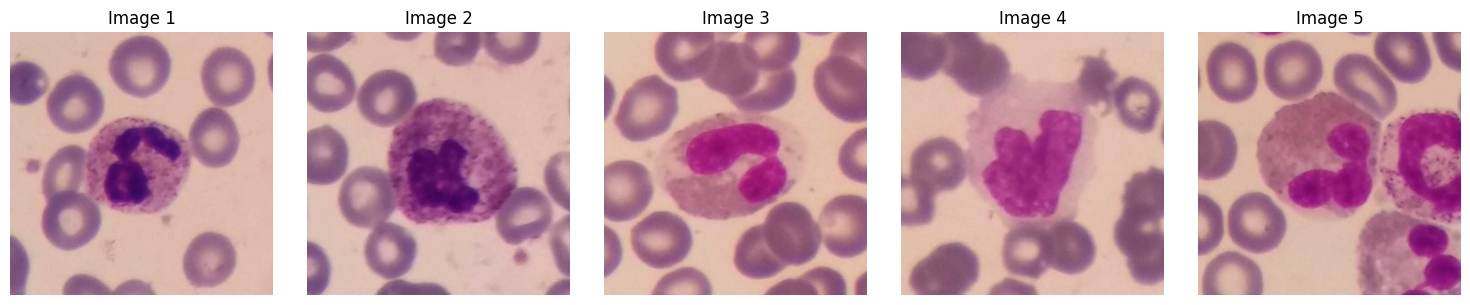

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

unlabeled_dir = "/content/semsup/unlabeled"
image_files = os.listdir(unlabeled_dir)[13:18]

plt.figure(figsize=(15, 3))
for i, image_file in enumerate(image_files):
    image_path = os.path.join(unlabeled_dir, image_file)
    image = Image.open(image_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()

### VGG16 model without fine-tuning
This section builds and trains the original VGG16 model without fine-tuning the pre-trained weights.  
The model is loaded with ImageNet weights, but the top fully connected layers are newly defined and trained from scratch.  
This serves as the baseline model for initial training and evaluation on the training and validation datasets.



In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Model Definition
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(227, 227, 3))

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(4, activation="softmax") 
])

# model_compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculating steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Model training
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop],
)

# Model saving
model.save("vgg16_pretrained_no_finetune.h5")

### Performance Plots (Accuracy & Loss)
> The following plots illustrate the training progress of the model, including accuracy and loss over epochs for both the training and validation datasets.    
> To enhance readability, **smoothing** techniques have been applied to the curves.    
> These visualizations help in understanding model behavior, detecting overfitting or underfitting, and evaluating overall performance.    
> Such insights are essential for making informed decisions in subsequent model improvements.


In [ ]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy
plt.plot(epochs, smooth_curve(acc), label='Train Acc', color='royalblue')
plt.plot(epochs, smooth_curve(val_acc), label='Val Acc', color='darkorange')
plt.title('Smoothed Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# loss
plt.plot(epochs, smooth_curve(loss), label='Train Loss', color='royalblue')
plt.plot(epochs, smooth_curve(val_loss), label='Val Loss', color='darkorange')
plt.title('Smoothed Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Fine-tuning VGG16 Model

In this section, we fine-tune the pre-trained VGG16 model on our specific dataset. By leveraging transfer learning, the base convolutional layers of VGG16 (trained on ImageNet) are frozen initially, and we add custom dense layers on top to adapt the model for our classification task. Fine-tuning allows the model to adjust its weights more precisely to our data, improving accuracy and generalization.


In [ ]:
# Load pre-trained VGG19 base model without top layers
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(227, 227, 3))

# Freeze layers up to 'block4_conv1' and fine-tune from this layer onward
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Load previously trained dense layers weights from a saved model
loaded_model = load_model('/content/drive/My Drive/TOTAL_new2.h5')

# Build new model with the VGG19 conv base and new dense layers
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Set weights of dense layers from loaded model to preserve previous training
model.layers[2].set_weights(loaded_model.layers[2].get_weights())
model.layers[3].set_weights(loaded_model.layers[3].get_weights())

# Compile the model with a low learning rate for fine-tuning
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with data generators (defined previously)
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=5
)
